# Clustering

This notebook is used to cluster the social media posts of the State Election Officials based on different features.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from ast import literal_eval
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as sch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap.umap_ as umap
from matplotlib.colors import LinearSegmentedColormap
import ast

/Users/jbm/miniforge3/envs/mdi_tone/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


do for 2022 and 2024 too

In [2]:
df = pd.read_csv('../data/clean/Clustering_with_info.csv')

In [3]:
df.head()

PostId                                               text  Platform  \
0  80072838  On November 29, the State Canvassing Board cer...  Facebook   
1  80076411  The State Canvassing Board certified the 2022 ...   Twitter   
2  80107630  : To all Baltimore County Election Judges who ...   Twitter   
3  80070562               See you bright and early, Owensboro.   Twitter   
4  80066551               See you bright and early, Owensboro.  Facebook   

   ChannelID                                         embeddings      State  \
0    8894188  [-0.4845951199531555, 0.4088035225868225, 0.41...  Minnesota   
1    8891709  [-0.5558313727378845, 0.41650187969207764, 0.4...  Minnesota   
2    8891704  [0.26043787598609924, -0.23166483640670776, 0....   Maryland   
3    8891702  [-0.2955371141433716, -0.05654048174619675, -0...   Kentucky   
4    8894179  [-0.2955371141433716, -0.05654048174619675, -0...   Kentucky   

   tenure_2024 party_2024 prez_winner_2024 prez_winner_2020  \
0            9          D                D                D   
1            9          D                D                D   
2            1        NaN                D                D   
3            4          R                R                R   
4            4          R                R                R   

   battleground_2020  battleground_2024  
0                  1                  0  
1                  1                  0  
2                  0                  0  
3                  0                  0  
4                  0                  0

In [4]:
# min and max value in tenure_2024 and battleground_2020 and battleground_2024
print(df['tenure_2024'].min(), df['tenure_2024'].max())
print(df['battleground_2020'].min(), df['battleground_2020'].max())
print(df['battleground_2024'].min(), df['battleground_2024'].max())
# min and max value in tenure_2024 and battleground_2020 and battleground_2024
print(df['tenure_2024'].min(), df['tenure_2024'].max())
print(df['battleground_2020'].min(), df['battleground_2020'].max())

0 29
0 1
0 1
0 29
0 1


In [5]:
len(df)

21118

In [6]:
df['embeddings'] = df['embeddings'].apply(
    lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else np.array(x)
)
matrix = np.vstack(df.embeddings.values)
matrix.shape # number of posts x number of embedding dimensions

(21118, 1024)

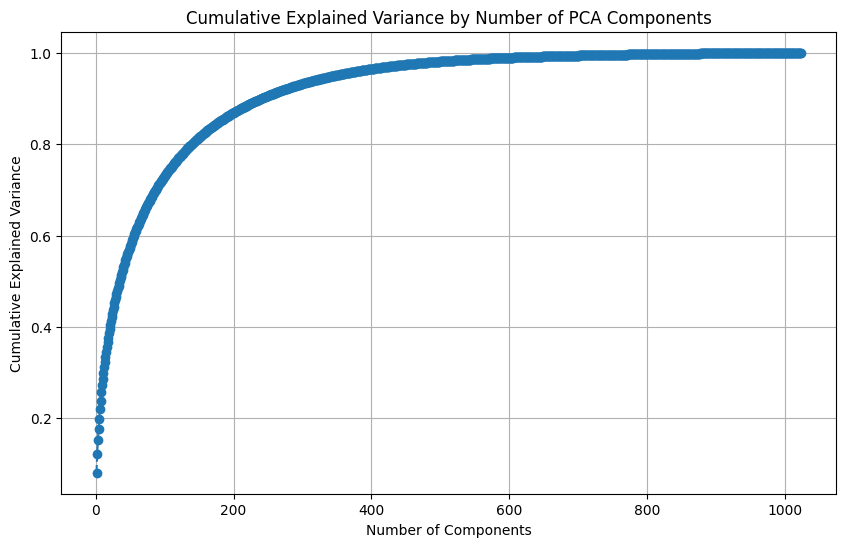

Number of components to retain 90.0% variance: 241
Original matrix shape: (21118, 1024)
PCA matrix shape: (21118, 241)


In [7]:
# first, we use PCA to reduce the dimensionality of the embeddings, so that we can later visualize them in 2D
pca = PCA().fit(matrix)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Number of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

desired_variance = 0.9
num_components = np.argmax(cumulative_variance >= desired_variance) + 1

print(f"Number of components to retain {desired_variance*100}% variance: {num_components}")

pca = PCA(n_components=num_components)
pca_matrix = pca.fit_transform(matrix)

print(f"Original matrix shape: {matrix.shape}")
print(f"PCA matrix shape: {pca_matrix.shape}")

In [8]:
# next, we use t-SNE to further reduce the dimensionality of the embeddings to 2D
tsne = TSNE(n_components=2, perplexity=68, random_state=21, init='random', learning_rate=200) # setting perplexity to sqrt(4668) as per Oskolkov (2022)
vis_dims = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims]
y = [y for x, y in vis_dims]

df['x_tsne'] = x # dimension 1 as obtained from t-SNE
df['y_tsne'] = y # dimension 2 as obtained from t-SNE

In [9]:
tsne_pca = TSNE(n_components=2, perplexity=68, random_state=21, init='random', learning_rate=200) # setting perplexity to sqrt(4668) as per Oskolkov (2022)
vis_dims_pca = tsne_pca.fit_transform(pca_matrix)

x = [x for x, y in vis_dims_pca]
y = [y for x, y in vis_dims_pca]

df['x_pca_tsne'] = x # dimension 1 as obtained from t-SNE
df['y_pca_tsne'] = y # dimension 2 as obtained from t-SNE

## t-SNE

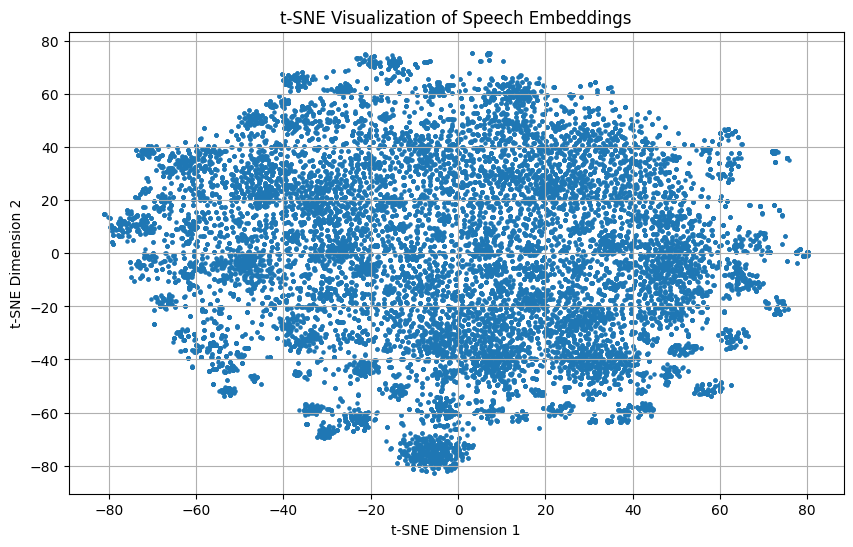

In [10]:
# plot a figure of the tsne results
plt.figure(figsize=(10, 6))
plt.scatter(df['x_tsne'], df['y_tsne'], s=5)
plt.title('t-SNE Visualization of Speech Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

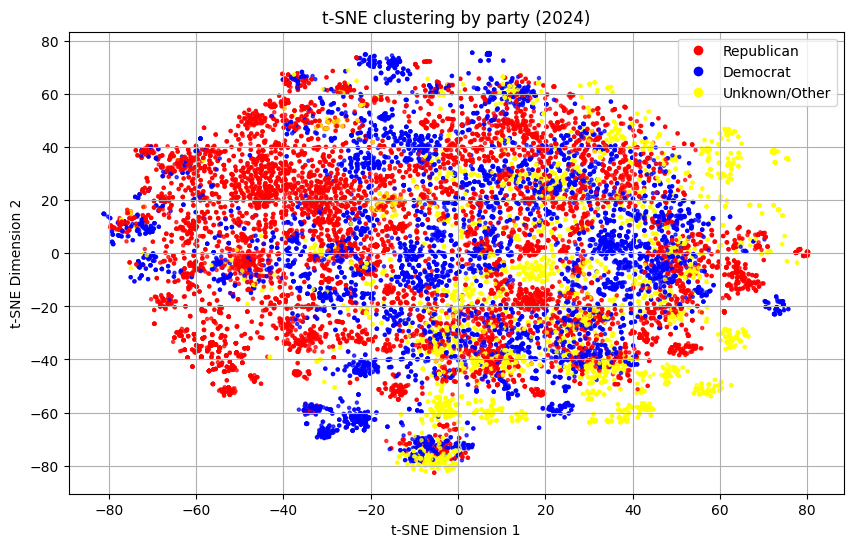

In [11]:
# plot a figure of the tsne results
plt.figure(figsize=(10, 6))

# Create a color map for the parties
colors = {'R': 'red', 'D': 'blue'}
# Apply color mapping (NaN values will be colored yellow)
scatter = plt.scatter(df['x_tsne'], df['y_tsne'], 
                     c=df['party_2024'].map(colors).fillna('yellow'), 
                     s=5, alpha=0.7)

plt.title('t-SNE clustering by party (2024)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Republican'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Democrat'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=8, label='Unknown/Other')
]
plt.legend(handles=legend_elements, loc='best')

plt.show()

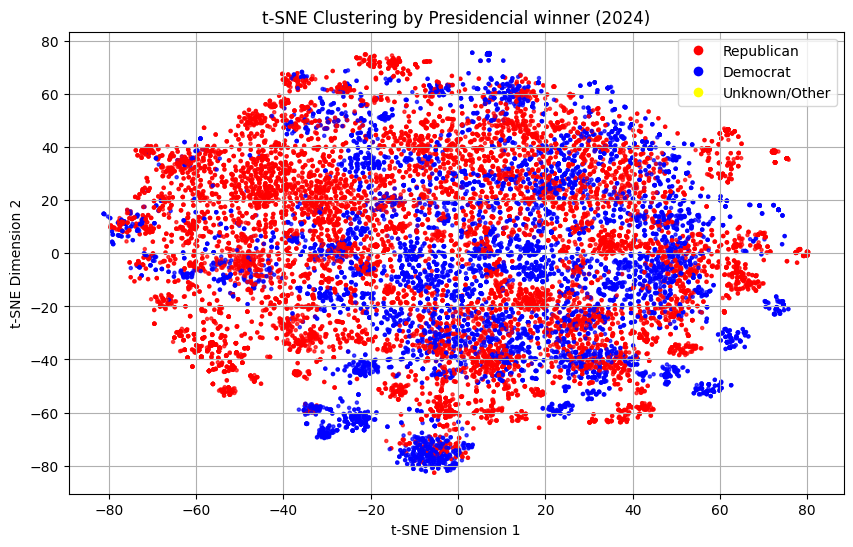

In [12]:
# plot a figure of the tsne results
plt.figure(figsize=(10, 6))

# Create a color map for the parties
colors = {'R': 'red', 'D': 'blue'}
# Apply color mapping (NaN values will be colored yellow)
scatter = plt.scatter(df['x_tsne'], df['y_tsne'], 
                     c=df['prez_winner_2024'].map(colors).fillna('yellow'), 
                     s=5, alpha=0.7)

plt.title('t-SNE Clustering by Presidencial winner (2024)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Republican'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Democrat'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=8, label='Unknown/Other')
]
plt.legend(handles=legend_elements, loc='best')

plt.show()

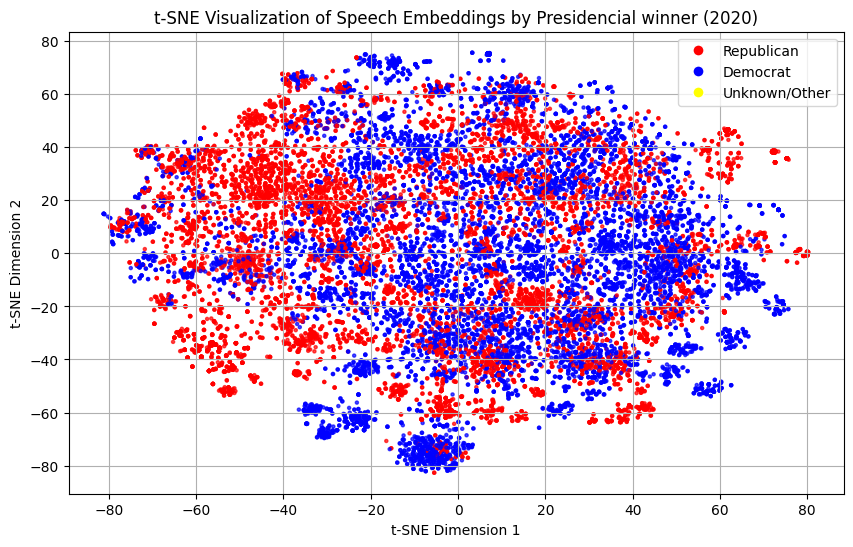

In [13]:
# plot a figure of the tsne results
plt.figure(figsize=(10, 6))

# Create a color map for the parties
colors = {'R': 'red', 'D': 'blue'}
# Apply color mapping (NaN values will be colored yellow)
scatter = plt.scatter(df['x_tsne'], df['y_tsne'], 
                     c=df['prez_winner_2020'].map(colors).fillna('yellow'), 
                     s=5, alpha=0.7)

plt.title('t-SNE Visualization of Speech Embeddings by Presidencial winner (2020)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Republican'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Democrat'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=8, label='Unknown/Other')
]
plt.legend(handles=legend_elements, loc='best')

plt.show()

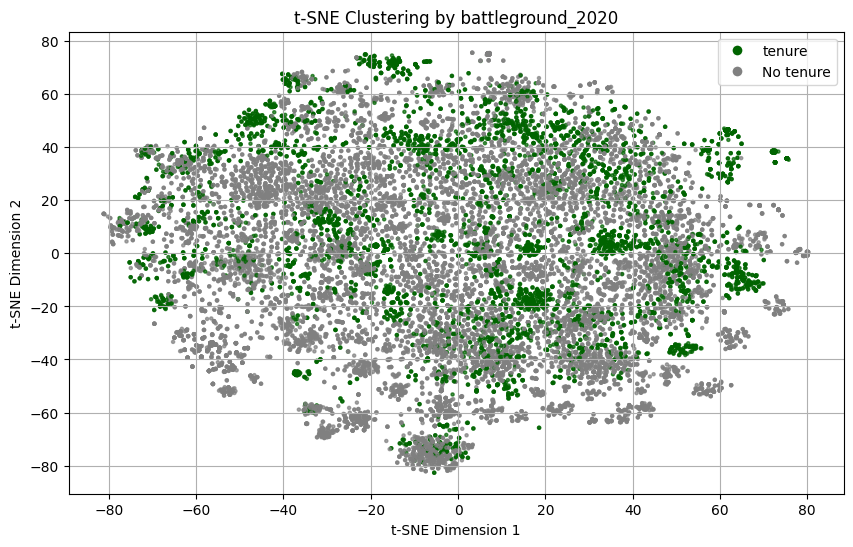

In [ ]:
# plot a figure of the tsne results
plt.figure(figsize=(10, 6))

# Create a color map for the parties
colors = {1: 'darkgreen', 0: 'gray'}
# Apply color mapping (NaN values will be colored yellow)
scatter = plt.scatter(df['x_tsne'], df['y_tsne'], 
                     c=df['battleground_2020'].map(colors).fillna('yellow'), 
                     s=5, alpha=0.7)

plt.title('t-SNE Clustering by battleground (2020)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkgreen', markersize=8, label='tenure'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, label='No tenure'),
    #plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=8, label='Unknown/Other')
]
plt.legend(handles=legend_elements, loc='best')

plt.show()

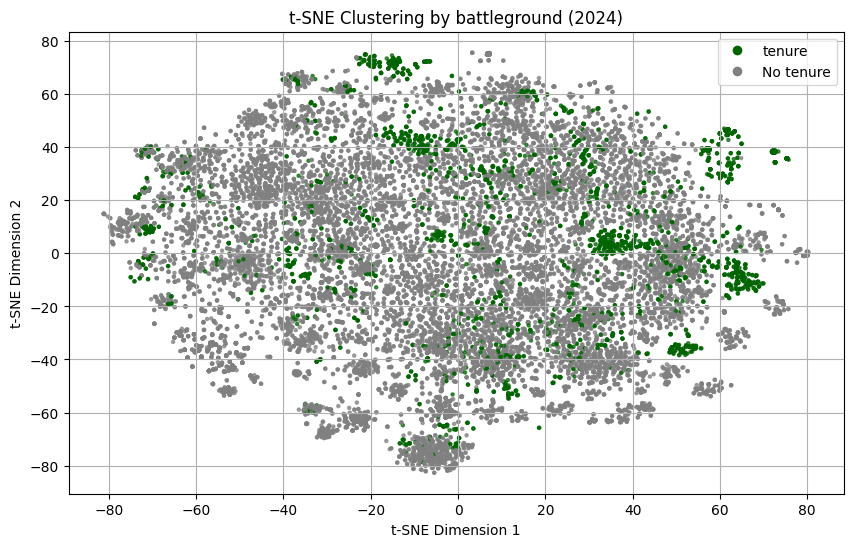

In [15]:
# plot a figure of the tsne results
plt.figure(figsize=(10, 6))

# Create a color map for the parties
colors = {1: 'darkgreen', 0: 'gray'}
# Apply color mapping (NaN values will be colored yellow)
scatter = plt.scatter(df['x_tsne'], df['y_tsne'], 
                     c=df['battleground_2024'].map(colors).fillna('yellow'), 
                     s=5, alpha=0.7)

plt.title('t-SNE Clustering by battleground (2024)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkgreen', markersize=8, label='tenure'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, label='No tenure'),
    #plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=8, label='Unknown/Other')
]
plt.legend(handles=legend_elements, loc='best')

plt.show()

## t-SNE with PCA preprocessing

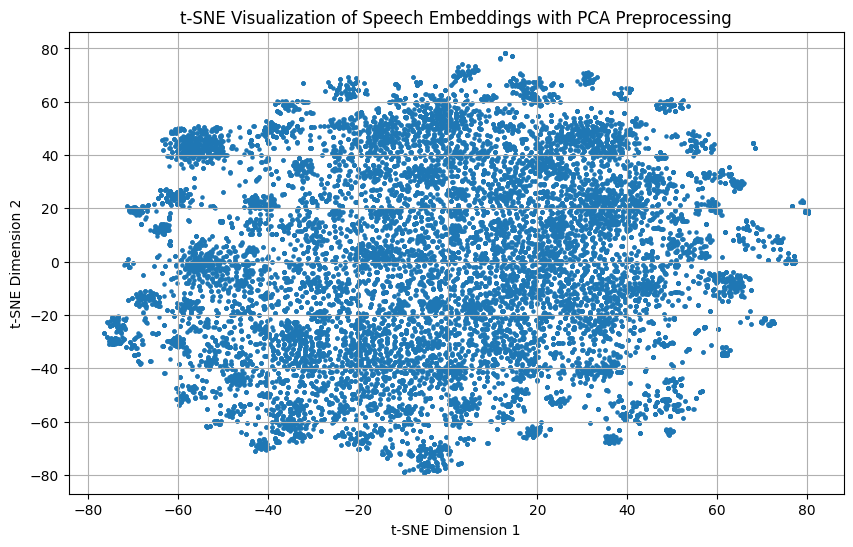

In [16]:
# plot a figure of the tsne results with pca preprocessing
plt.figure(figsize=(10, 6))
plt.scatter(df['x_pca_tsne'], df['y_pca_tsne'], s=5)
plt.title('t-SNE Visualization of Speech Embeddings with PCA Preprocessing')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

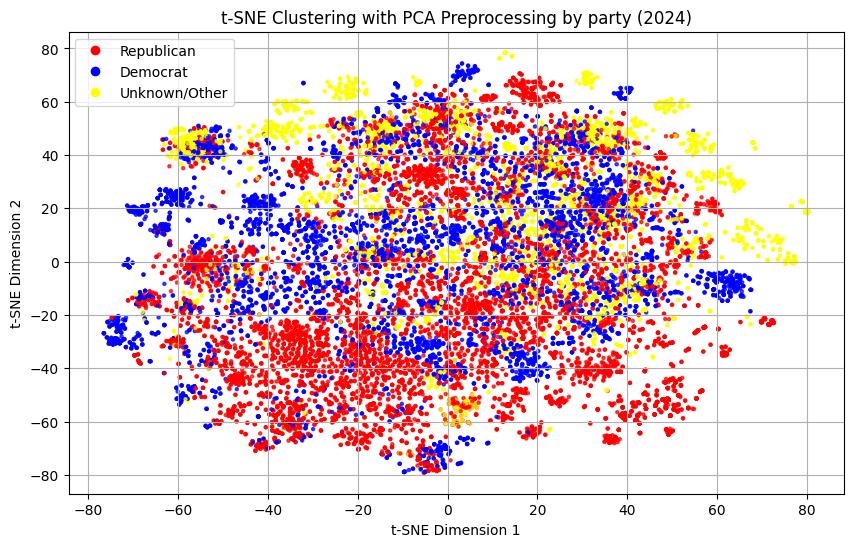

In [17]:
# plot a figure of the tsne results with pca preprocessing
plt.figure(figsize=(10, 6))

# Create a color map for the parties
colors = {'R': 'red', 'D': 'blue'}
# Apply color mapping (NaN values will be colored yellow)
scatter = plt.scatter(df['x_pca_tsne'], df['y_pca_tsne'], 
                     c=df['party_2024'].map(colors).fillna('yellow'), 
                     s=5, alpha=0.7)

plt.title('t-SNE Clustering with PCA Preprocessing by party (2024)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Republican'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Democrat'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=8, label='Unknown/Other')
]
plt.legend(handles=legend_elements, loc='best')

plt.show()

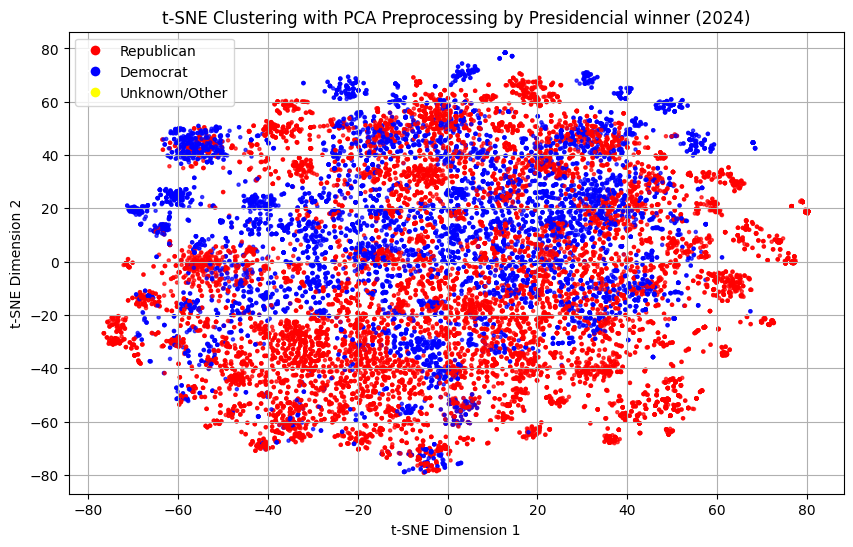

In [18]:
# plot a figure of the tsne results with pca preprocessing
plt.figure(figsize=(10, 6))

# Create a color map for the parties
colors = {'R': 'red', 'D': 'blue'}
# Apply color mapping (NaN values will be colored yellow)
scatter = plt.scatter(df['x_pca_tsne'], df['y_pca_tsne'], 
                     c=df['prez_winner_2024'].map(colors).fillna('yellow'), 
                     s=5, alpha=0.7)

plt.title('t-SNE Clustering with PCA Preprocessing by Presidencial winner (2024)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Republican'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Democrat'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=8, label='Unknown/Other')
]
plt.legend(handles=legend_elements, loc='best')

plt.show()

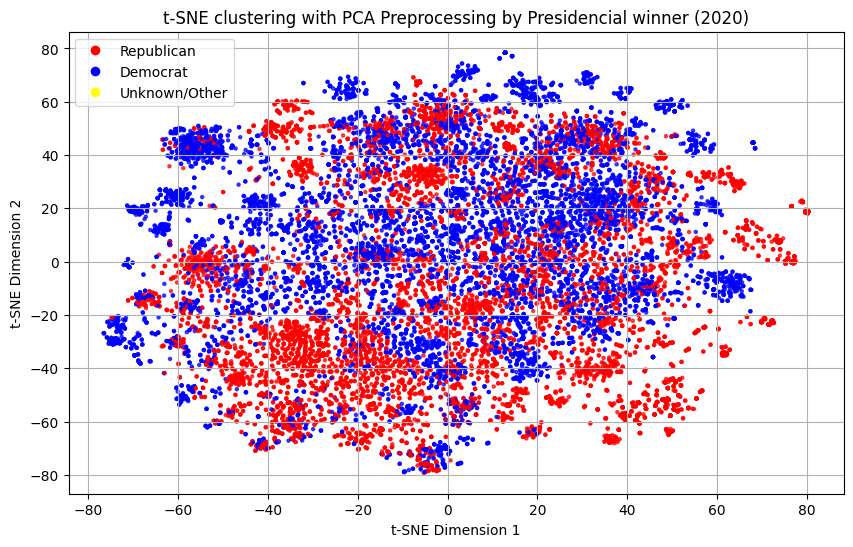

In [30]:
# plot a figure of the tsne results with pca preprocessing
plt.figure(figsize=(10, 6))

# Create a color map for the parties
colors = {'R': 'red', 'D': 'blue'}
# Apply color mapping (NaN values will be colored yellow)
scatter = plt.scatter(df['x_pca_tsne'], df['y_pca_tsne'], 
                     c=df['prez_winner_2020'].map(colors).fillna('yellow'), 
                     s=5, alpha=0.7)

plt.title('t-SNE clustering with PCA Preprocessing by Presidencial winner (2020)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Republican'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Democrat'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=8, label='Unknown/Other')
]
plt.legend(handles=legend_elements, loc='best')

plt.show()

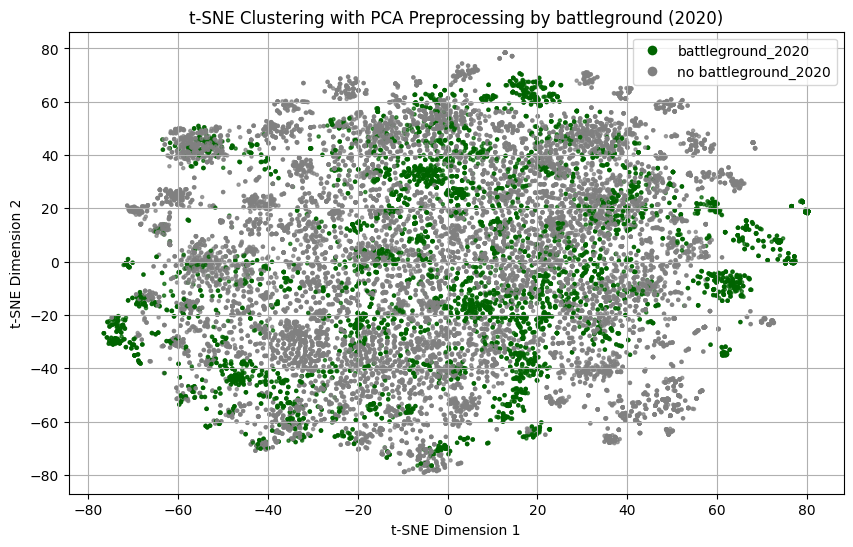

In [20]:
# plot a figure of the tsne results with pca preprocessing
plt.figure(figsize=(10, 6))

# Create a color map for the parties
colors = {1: 'darkgreen', 0: 'gray'}
# Apply color mapping (NaN values will be colored yellow)
scatter = plt.scatter(df['x_pca_tsne'], df['y_pca_tsne'], 
                     c=df['battleground_2020'].map(colors).fillna('yellow'), 
                     s=5, alpha=0.7)

plt.title('t-SNE Clustering with PCA Preprocessing by battleground (2020)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkgreen', markersize=8, label='battleground_2020'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, label='no battleground_2020'),
    # plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=8, label='Unknown/Other')
]
plt.legend(handles=legend_elements, loc='best')

plt.show()

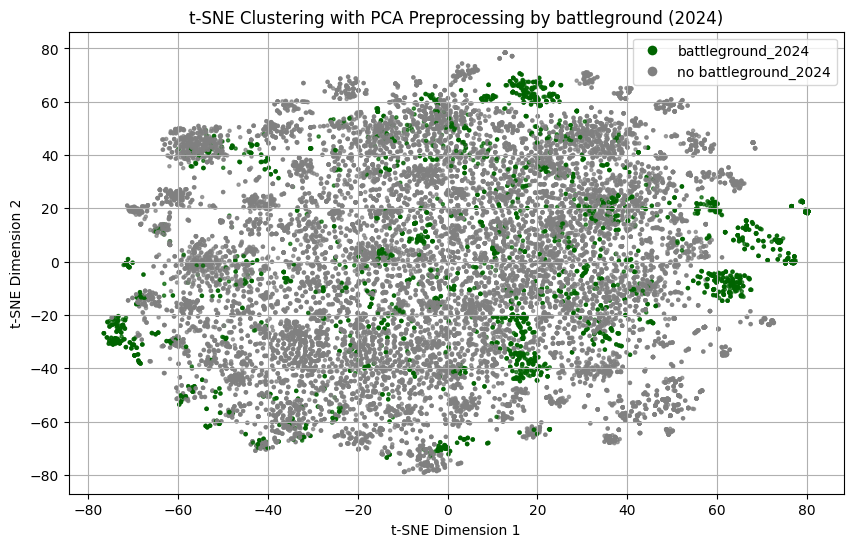

In [21]:
# plot a figure of the tsne results with pca preprocessing
plt.figure(figsize=(10, 6))

# Create a color map for the parties
colors = {1: 'darkgreen', 0: 'gray'}
# Apply color mapping (NaN values will be colored yellow)
scatter = plt.scatter(df['x_pca_tsne'], df['y_pca_tsne'], 
                     c=df['battleground_2024'].map(colors).fillna('yellow'), 
                     s=5, alpha=0.7)

plt.title('t-SNE Clustering with PCA Preprocessing by battleground (2024)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkgreen', markersize=8, label='battleground_2024'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=8, label='no battleground_2024'),
    # plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=8, label='Unknown/Other')
]
plt.legend(handles=legend_elements, loc='best')

plt.show()

## UMAP

### hyperparameters: 
### n_neighbors set to sqrt(144) (square root of the number of datapoints) as per Oskolkov (2022)
### n_components set to 5 as per Reades and Williams (2023) in order to capture more variance

/Users/jbm/miniforge3/envs/mdi_tone/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


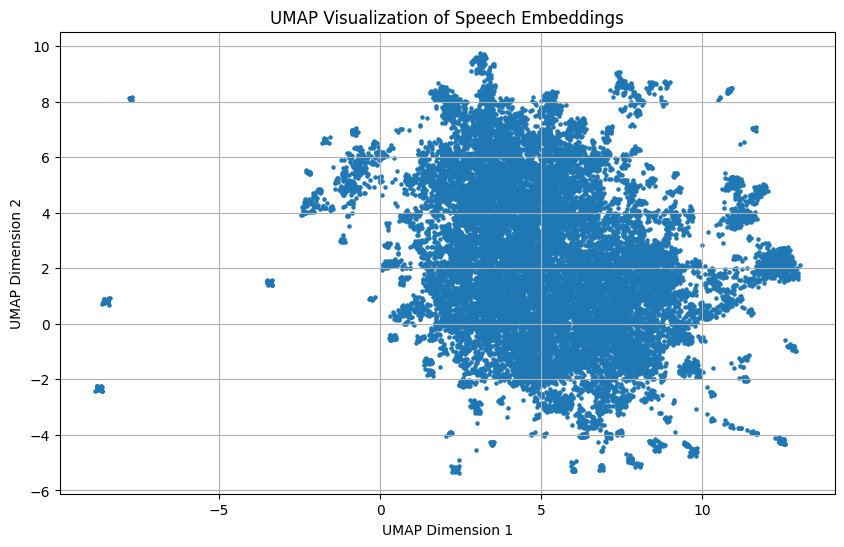

In [22]:
# UMAP with only two dimensions
umap_model = umap.UMAP(n_components=2, n_neighbors=150, min_dist=0.5,init='random', random_state=9, n_jobs=1)
vis_dims2 = umap_model.fit_transform(matrix)

df['x_umap2'], df['y_umap2'] = vis_dims2[:, 0], vis_dims2[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(df['x_umap2'], df['y_umap2'], s=5)
plt.title('UMAP Visualization of Speech Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)
plt.show()

/Users/jbm/miniforge3/envs/mdi_tone/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


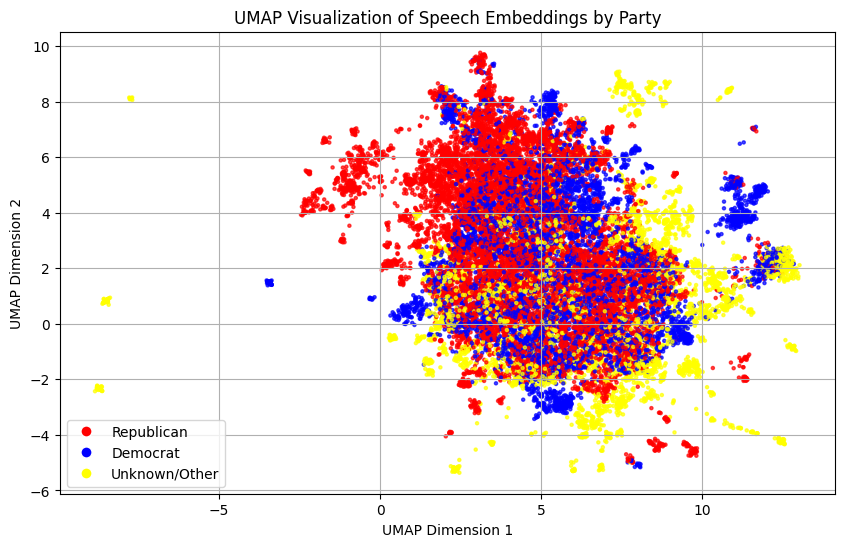

In [23]:
# UMAP with only two dimensions
umap_model = umap.UMAP(n_components=2, n_neighbors=150, min_dist=0.5,init='random', random_state=9, n_jobs=1)
vis_dims2 = umap_model.fit_transform(matrix)

df['x_umap2'], df['y_umap2'] = vis_dims2[:, 0], vis_dims2[:, 1]

plt.figure(figsize=(10, 6))

# Create a color map for the parties
colors = {'R': 'red', 'D': 'blue'}
# Apply color mapping (NaN values will be colored yellow)
scatter = plt.scatter(df['x_umap2'], df['y_umap2'], 
                     c=df['party_2024'].map(colors).fillna('yellow'), 
                     s=5, alpha=0.7)

plt.title('UMAP Visualization of Speech Embeddings by Party')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Republican'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Democrat'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=8, label='Unknown/Other')
]
plt.legend(handles=legend_elements, loc='best')

plt.show()

## UMAP with PCA preprocessing

/Users/jbm/miniforge3/envs/mdi_tone/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


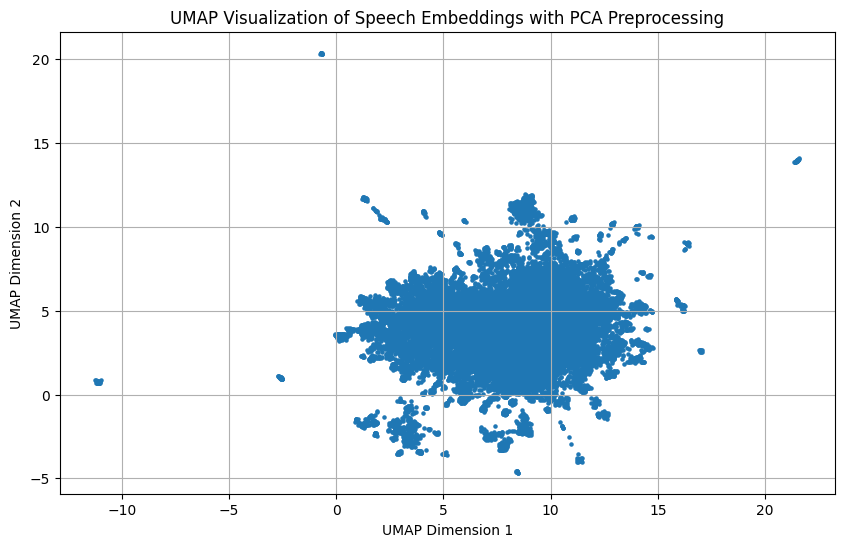

In [24]:
# umap visualization with 2 dimensions and pca preprocessing
umap_model = umap.UMAP(n_components=2, n_neighbors=150, min_dist=0.5,init='random', random_state=9, n_jobs=1)
vis_dims2_pca = umap_model.fit_transform(pca_matrix)

df['x_umap2_pca'], df['y_umap2_pca'] = vis_dims2_pca[:, 0], vis_dims2_pca[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(df['x_umap2_pca'], df['y_umap2_pca'], s=5)
plt.title('UMAP Visualization of Speech Embeddings with PCA Preprocessing')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)
plt.show()

/Users/jbm/miniforge3/envs/mdi_tone/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


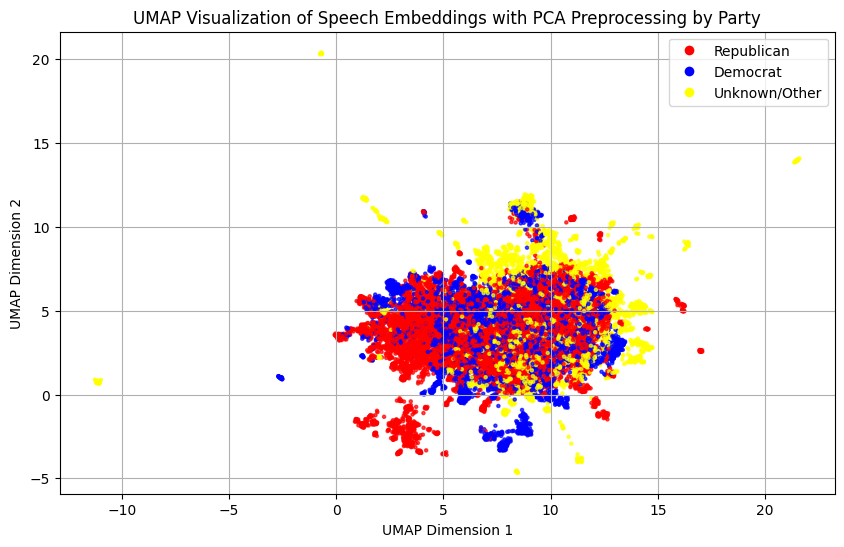

In [25]:
# umap visualization with 2 dimensions and pca preprocessing
umap_model = umap.UMAP(n_components=2, n_neighbors=150, min_dist=0.5,init='random', random_state=9, n_jobs=1)
vis_dims2_pca = umap_model.fit_transform(pca_matrix)

df['x_umap2_pca'], df['y_umap2_pca'] = vis_dims2_pca[:, 0], vis_dims2_pca[:, 1]

plt.figure(figsize=(10, 6))

# Create a color map for the parties
colors = {'R': 'red', 'D': 'blue'}
# Apply color mapping (NaN values will be colored yellow)
scatter = plt.scatter(df['x_umap2_pca'], df['y_umap2_pca'], 
                     c=df['party_2024'].map(colors).fillna('yellow'), 
                     s=5, alpha=0.7)

plt.title('UMAP Visualization of Speech Embeddings with PCA Preprocessing by Party')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(True)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Republican'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Democrat'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=8, label='Unknown/Other')
]
plt.legend(handles=legend_elements, loc='best')

plt.show()

KeyError: 'x_umap'

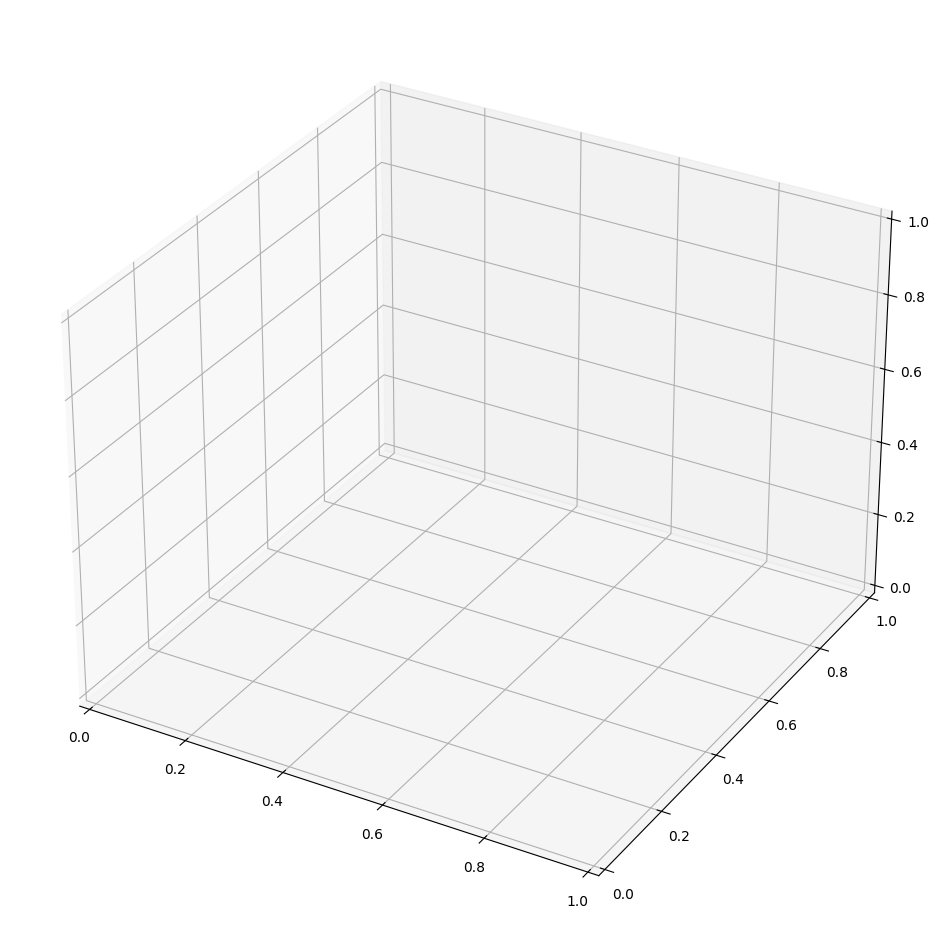

In [26]:
# add color marking by party to the UMAP plot with 3 dimensions
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Create a color map for the parties
colors = {'R': 'red', 'D': 'blue', np.nan: 'yellow'}

# Map the party_2024 values to colors
party_colors = df['party_2024'].map(colors).fillna('yellow')

sc = ax.scatter(
    df['x_umap'], 
    df['y_umap'], 
    df['z_umap'], 
    c=party_colors,         
    marker='o',        
    edgecolors='w',   
    s=50,                 
)

ax.set_xlabel('UMAP Dimension 1', fontsize=12)
ax.set_ylabel('UMAP Dimension 2', fontsize=12)
ax.set_zlabel('UMAP Dimension 3', fontsize=12)
ax.set_title('3D UMAP Visualization of Embeddings by Party', fontsize=16)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Republican'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Democrat'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Unknown/Other')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.show()

## DBSCAN

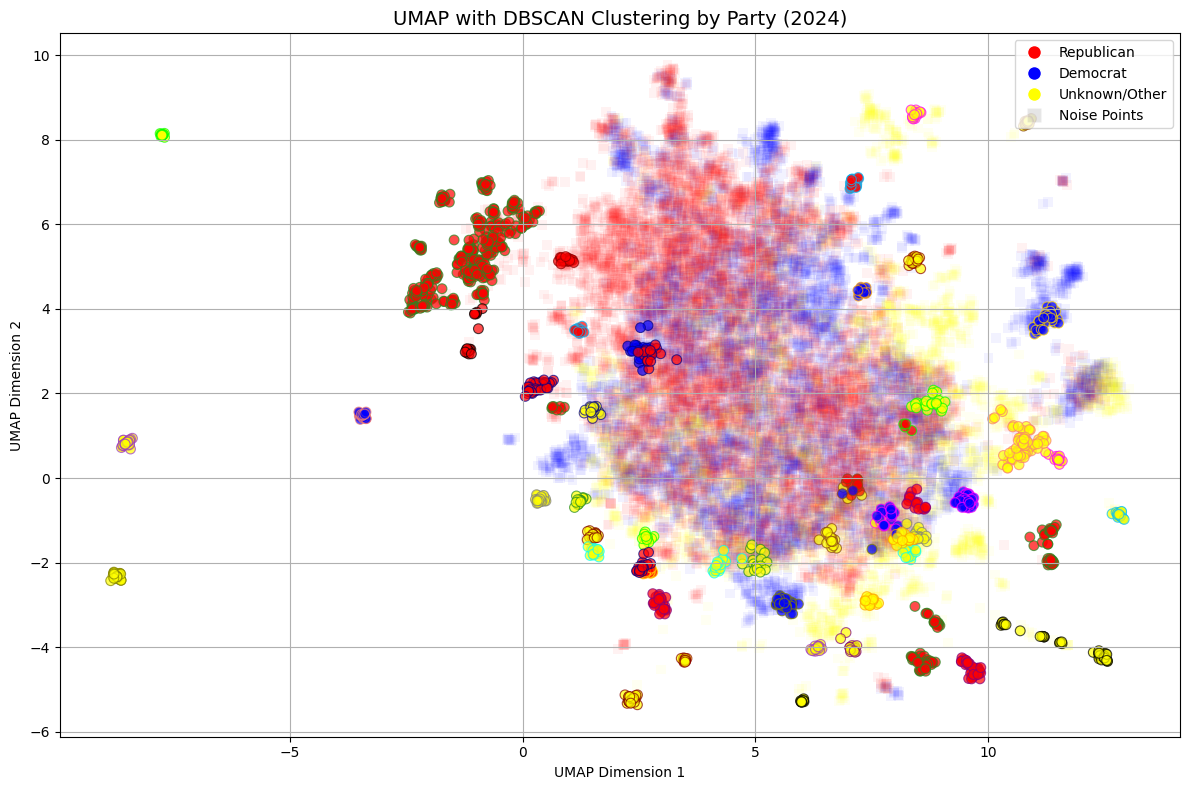

Total number of texts considered noise by DBSCAN: 19367


In [31]:
# dbscan clustering for UMAP with 2 dimensions
def dbscan_clustering(matrix, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(matrix)
    return labels

def plot_clusters_dbscan(df, x_col, y_col, eps, min_samples):
    unique_clusters = sorted(df['dbscan'].unique())
    outline_colors = [
        'maroon', 'forestgreen', 'navy', 'gold', 'purple', 
        'cyan', 'orange', 'darkred', 'deepskyblue', 'saddlebrown', 
        'lime', 'black', 'magenta', 'darkblue', 'salmon', 
        'darkorchid', 'olive', 'gray'
    ]
    color_map = {label: outline_colors[idx % len(outline_colors)] for idx, label in enumerate(unique_clusters)}
    
    # Party color map
    party_colors = {'R': 'red', 'D': 'blue'}
    
    plt.figure(figsize=(12, 8))
    
    # First plot outliers (noise points) with lower alpha to make them dimmer
    noise_subset = df[df['dbscan'] == -1]
    if not noise_subset.empty:
        noise_color_values = noise_subset['party_2024'].map(party_colors).fillna('yellow')
        plt.scatter(
            noise_subset[x_col], 
            noise_subset[y_col], 
            c=noise_color_values,  
            edgecolors='w',  # white outline for noise
            linewidths=0.3,  # thinner outline for noise
            s=50,          
            marker='s',   
            alpha=0.05  # Much lower alpha for noise points to dim them
        )
    
    # Then plot regular cluster points
    for idx, cluster_label in enumerate(unique_clusters):
        if cluster_label == -1:  # Skip noise points since we already plotted them
            continue
            
        cluster_subset = df[df['dbscan'] == cluster_label]
        
        # Color points by party
        party_color_values = cluster_subset['party_2024'].map(party_colors).fillna('yellow')
        
        plt.scatter(
            cluster_subset[x_col], 
            cluster_subset[y_col], 
            c=party_color_values,  
            edgecolors=color_map[cluster_label],  # colored outline for clusters
            linewidths=0.8,  # thicker outline for clusters
            s=50,          
            marker='o',   
            alpha=0.7
        )
    
    # Add plot title and labels
    plt.title(f'UMAP with DBSCAN Clustering by Party (2024)', fontsize=14)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    
    # Add legend for party colors
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Republican'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Democrat'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Unknown/Other'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=10, alpha=0.2, label='Noise Points')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

eps = 7.5 #6.5
min_samples = 15 #5

df['dbscan'] = dbscan_clustering(matrix, eps=eps, min_samples=min_samples)

plot_clusters_dbscan(df, 'x_umap2', 'y_umap2', eps, min_samples)

total_noise = (df['dbscan'] == -1).sum()
print(f"Total number of texts considered noise by DBSCAN: {total_noise}")

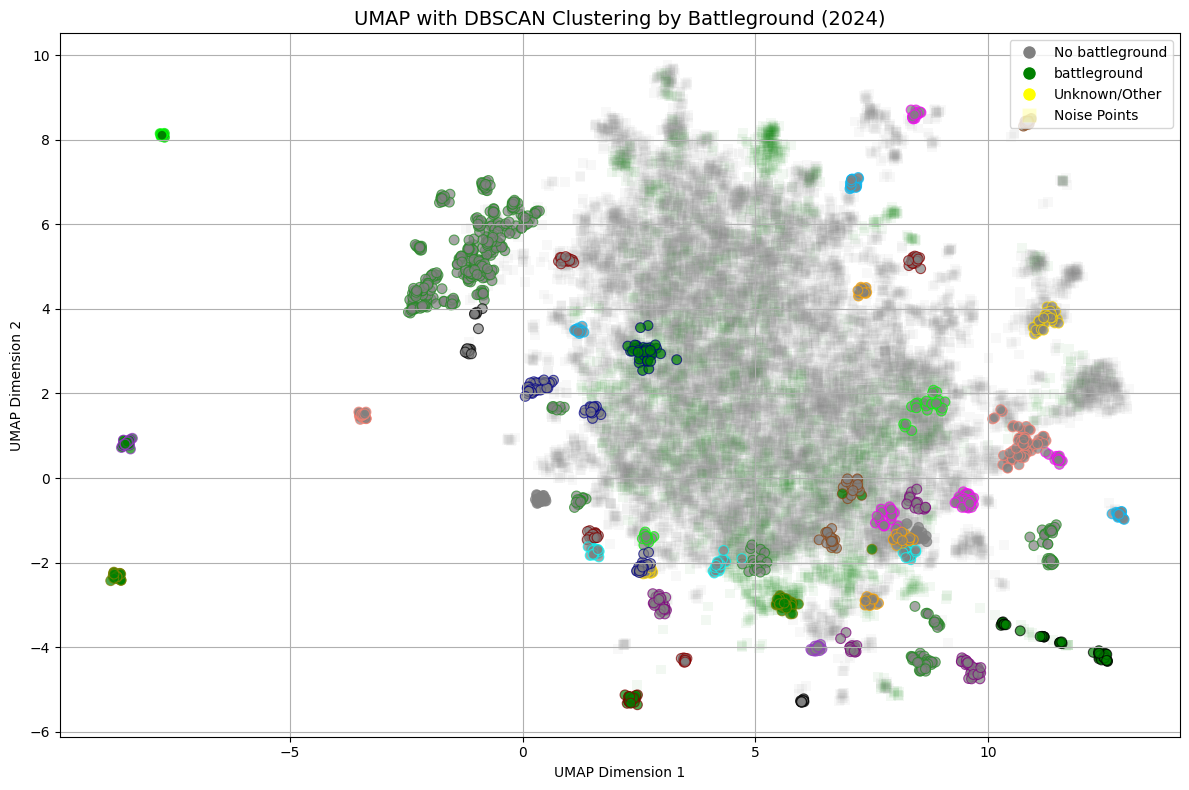

Total number of texts considered noise by DBSCAN: 19367


In [34]:
# dbscan clustering for UMAP with 2 dimensions
def dbscan_clustering(matrix, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(matrix)
    return labels

def plot_clusters_dbscan(df, x_col, y_col, eps, min_samples):
    unique_clusters = sorted(df['dbscan'].unique())
    outline_colors = [
        'maroon', 'forestgreen', 'navy', 'gold', 'purple', 
        'cyan', 'orange', 'darkred', 'deepskyblue', 'saddlebrown', 
        'lime', 'black', 'magenta', 'darkblue', 'salmon', 
        'darkorchid', 'olive', 'gray'
    ]
    color_map = {label: outline_colors[idx % len(outline_colors)] for idx, label in enumerate(unique_clusters)}
    
    # Party color map
    party_colors = {0.0: 'gray', 1.0: 'green'}
    
    plt.figure(figsize=(12, 8))
    
    # First plot outliers (noise points) with lower alpha to make them dimmer
    noise_subset = df[df['dbscan'] == -1]
    if not noise_subset.empty:
        noise_color_values = noise_subset['battleground_2024'].map(party_colors).fillna('yellow')
        plt.scatter(
            noise_subset[x_col], 
            noise_subset[y_col], 
            c=noise_color_values,  
            edgecolors='w',  # white outline for noise
            linewidths=0.3,  # thinner outline for noise
            s=50,          
            marker='s',   
            alpha=0.05  # Much lower alpha for noise points to dim them
        )
    
    # Then plot regular cluster points
    for idx, cluster_label in enumerate(unique_clusters):
        if cluster_label == -1:  # Skip noise points since we already plotted them
            continue
            
        cluster_subset = df[df['dbscan'] == cluster_label]
        
        # Color points by party
        party_color_values = cluster_subset['battleground_2024'].map(party_colors).fillna('yellow')
        
        plt.scatter(
            cluster_subset[x_col], 
            cluster_subset[y_col], 
            c=party_color_values,  
            edgecolors=color_map[cluster_label],  # colored outline for clusters
            linewidths=0.8,  # thicker outline for clusters
            s=50,          
            marker='o',   
            alpha=0.7
        )
    
    # Add plot title and labels
    plt.title(f'UMAP with DBSCAN Clustering by Battleground (2024)', fontsize=14)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    
    # Add legend for party colors
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='No battleground'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='battleground'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Unknown/Other'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='yellow', markersize=10, alpha=0.2, label='Noise Points')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

eps = 7.5 #6.5
min_samples = 15 #5

df['dbscan'] = dbscan_clustering(matrix, eps=eps, min_samples=min_samples)

plot_clusters_dbscan(df, 'x_umap2', 'y_umap2', eps, min_samples)

total_noise = (df['dbscan'] == -1).sum()
print(f"Total number of texts considered noise by DBSCAN: {total_noise}")

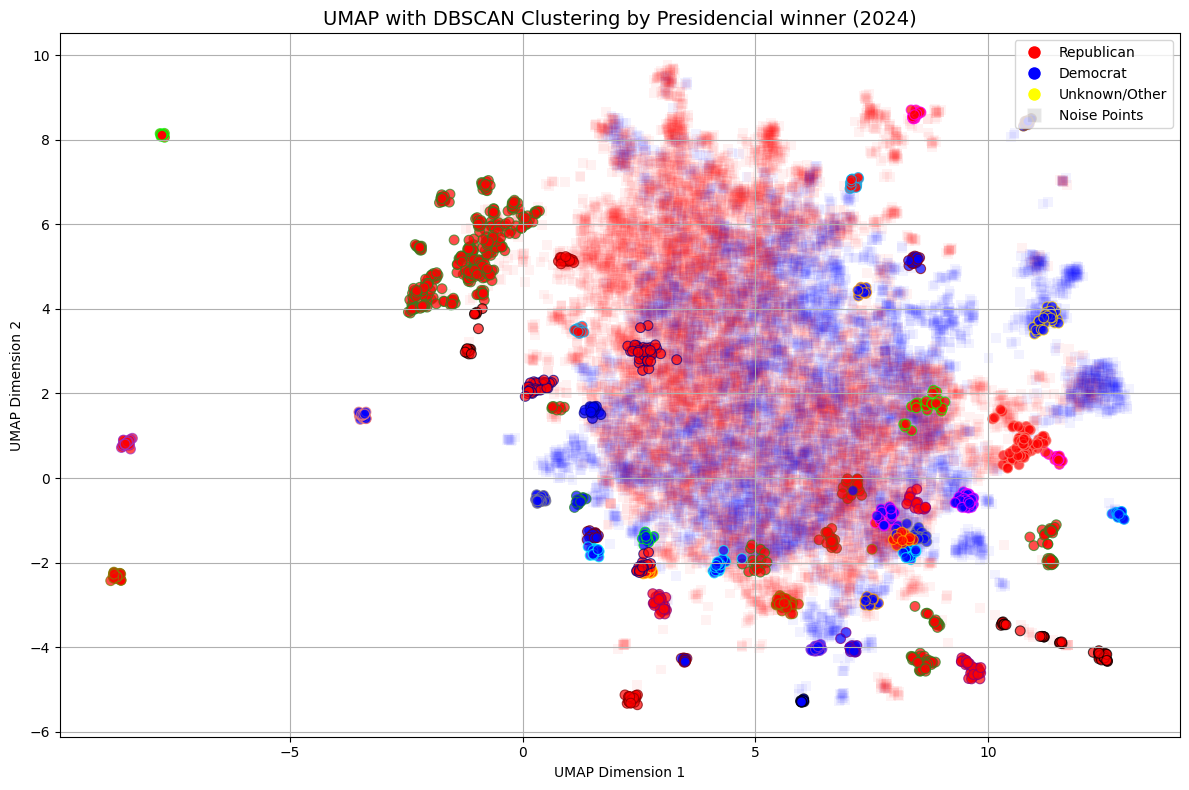

Total number of texts considered noise by DBSCAN: 19367


In [29]:
# dbscan clustering for UMAP with 2 dimensions
def dbscan_clustering(matrix, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(matrix)
    return labels

def plot_clusters_dbscan(df, x_col, y_col, eps, min_samples):
    unique_clusters = sorted(df['dbscan'].unique())
    outline_colors = [
        'maroon', 'forestgreen', 'navy', 'gold', 'purple', 
        'cyan', 'orange', 'darkred', 'deepskyblue', 'saddlebrown', 
        'lime', 'black', 'magenta', 'darkblue', 'salmon', 
        'darkorchid', 'olive', 'gray'
    ]
    color_map = {label: outline_colors[idx % len(outline_colors)] for idx, label in enumerate(unique_clusters)}
    
    # Party color map
    party_colors = {'R': 'red', 'D': 'blue'}
    
    plt.figure(figsize=(12, 8))
    
    # First plot outliers (noise points) with lower alpha to make them dimmer
    noise_subset = df[df['dbscan'] == -1]
    if not noise_subset.empty:
        noise_color_values = noise_subset['prez_winner_2024'].map(party_colors).fillna('yellow')
        plt.scatter(
            noise_subset[x_col], 
            noise_subset[y_col], 
            c=noise_color_values,  
            edgecolors='w',  # white outline for noise
            linewidths=0.3,  # thinner outline for noise
            s=50,          
            marker='s',   
            alpha=0.05  # Much lower alpha for noise points to dim them
        )
    
    # Then plot regular cluster points
    for idx, cluster_label in enumerate(unique_clusters):
        if cluster_label == -1:  # Skip noise points since we already plotted them
            continue
            
        cluster_subset = df[df['dbscan'] == cluster_label]
        
        # Color points by party
        party_color_values = cluster_subset['prez_winner_2024'].map(party_colors).fillna('yellow')
        
        plt.scatter(
            cluster_subset[x_col], 
            cluster_subset[y_col], 
            c=party_color_values,  
            edgecolors=color_map[cluster_label],  # colored outline for clusters
            linewidths=0.8,  # thicker outline for clusters
            s=50,          
            marker='o',   
            alpha=0.7
        )
    
    # Add plot title and labels
    plt.title(f'UMAP with DBSCAN Clustering by Presidencial winner (2024)', fontsize=14)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    
    # Add legend for party colors
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Republican'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Democrat'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='Unknown/Other'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=10, alpha=0.2, label='Noise Points')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

eps = 7.5 #6.5
min_samples = 15 #5

df['dbscan'] = dbscan_clustering(matrix, eps=eps, min_samples=min_samples)

plot_clusters_dbscan(df, 'x_umap2', 'y_umap2', eps, min_samples)

total_noise = (df['dbscan'] == -1).sum()
print(f"Total number of texts considered noise by DBSCAN: {total_noise}")